### all imports:

In [1]:
import pandas as pd
import shap
import numpy as np
import matplotlib.pyplot as plt
import datetime as dt
from datetime import datetime
from matplotlib.pylab import rcParams
from sklearn.model_selection import train_test_split
from sklearn import linear_model
rcParams['figure.figsize'] = 15, 6
plt.rcParams['agg.path.chunksize'] = 10000

### datacleaning:
- we first load the dataset

In [2]:
data = pd.read_csv('la-haute-borne-data-2017-2020.csv',sep=';')

In [3]:
data.head()

,Wind_turbine_name,Date_time,Ba_avg,Ba_min,Ba_max,Ba_std,Rt_avg,Rt_min,Rt_max,Rt_std,...,Pas_max,Pas_std,Wa_c_avg,Wa_c_min,Wa_c_max,Wa_c_std,Na_c_avg,Na_c_min,Na_c_max,Na_c_std
0,R80721,2017-02-08T08:00:00+01:00,44.990002,44.990002,44.990002,0.0,14.0,14.0,14.0,0.0,...,NaN,NaN,358.04999,NaN,NaN,NaN,358.04999,NaN,NaN,NaN
1,R80721,2017-01-26T02:40:00+01:00,-1.000000,-1.000000,-1.000000,0.0,10.0,10.0,10.0,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,R80721,2017-01-26T13:50:00+01:00,-1.000000,-1.000000,-1.000000,0.0,10.0,10.0,10.0,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,R80721,2017-01-26T15:00:00+01:00,-1.000000,-1.000000,-1.000000,0.0,10.0,10.0,10.0,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,R80721,2017-02-18T01:10:00+01:00,44.990002,44.990002,44.990002,0.0,17.0,17.0,17.0,0.0,...,NaN,NaN,7.99000,NaN,NaN,NaN,7.99000,NaN,NaN,NaN


- then we remove all empty columns

In [4]:
data = data.drop('Va1_avg', 1)
data = data.drop('Va2_avg', 1)
data = data.drop('Pas_avg', 1)

In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.


In [5]:
data["P_avg"].head()

0     -1.89000
1    197.32001
2    176.45000
3    190.61000
4     -2.88000
Name: P_avg, dtype: float64

- then we clip our windpower, so we do not have negative power

In [6]:
data["P_avg"] = data["P_avg"].clip(lower=0)

In [7]:
data["P_avg"].head()

0      0.00000
1    197.32001
2    176.45000
3    190.61000
4      0.00000
Name: P_avg, dtype: float64

- we have to convert our timestamp to a usefull format

In [8]:
data['Date_time'] = pd.to_datetime(data['Date_time'], utc=True)

data["date"] = pd.to_datetime(data['Date_time']).apply(lambda x: x.date())
data['monthdate'] = pd.DatetimeIndex(data['Date_time']).month
data['year'] = data['Date_time'].dt.year
data['month'] = data['Date_time'].dt.month
data['day'] = data['Date_time'].dt.day
data['year'] = data["year"].values
data['month'] = data["month"].values
data['day'] = data["day"].values

In [9]:
print("days: ",data['day'].head()) 
print("")
print("months: ",data['month'].head()) 
print("")
print("years :",data['year'].head())

days:  0     8
1    26
2    26
3    26
4    18
Name: day, dtype: int64

months:  0    2
1    1
2    1
3    1
4    2
Name: month, dtype: int64

years : 0    2017
1    2017
2    2017
3    2017
4    2017
Name: year, dtype: int64




- first we drop NaNs and delete outliers

In [10]:
selected_columns = data[["Date_time","P_avg","Ba_avg","Rt_avg","Yt_avg","Ws_avg","Ot_avg"]]
df = selected_columns.copy()
df.dropna(axis = 0, how ='any', inplace=True)
df = df[df['P_avg'].notna()]
df = df[df['Ba_avg'].notna()]
df = df[df['Rt_avg'].notna()]
df = df[df['Yt_avg'].notna()]
df = df[df['Ws_avg'].notna()]
df = df[df['Ot_avg'].notna()]

In [11]:
Ws = df.sort_values(by=["Ws_avg"], ascending=False) # Wind speed
Ot = df.sort_values(by=["Ot_avg"], ascending=False) # temperature
Yt = df.sort_values(by=["Yt_avg"], ascending=False) # nacelle temperature
Rt = df.sort_values(by=["Rt_avg"], ascending=False) # hub temperature
Ba = df.sort_values(by=["Ba_avg"], ascending=False) # pitch angle

- we look at every column to see whether there appear some untypical numbers or not.

In [12]:
Ws.head() 

,Date_time,P_avg,Ba_avg,Rt_avg,Yt_avg,Ws_avg,Ot_avg
212826,2018-01-03 07:20:00+00:00,284.88,78.71,18.32,16.30,24.27,8.12
210705,2018-01-03 07:20:00+00:00,545.07,66.90,17.92,16.36,23.48,7.76
177441,2018-01-03 07:20:00+00:00,1296.88,44.33,19.00,16.07,23.00,7.77
212232,2018-01-03 04:30:00+00:00,2048.26,19.92,18.00,19.32,21.67,12.54
173248,2018-01-03 05:20:00+00:00,1436.69,38.10,18.77,18.46,21.30,11.39


--> no outliers in Windspeed

In [13]:
Ot.head()

,Date_time,P_avg,Ba_avg,Rt_avg,Yt_avg,Ws_avg,Ot_avg
74205,2017-02-03 13:50:00+00:00,4.3,75.300003,15.46,39.560001,7.90,70.980003
15679,2017-02-03 13:40:00+00:00,0.0,91.699997,15.16,56.090000,6.08,68.699997
108390,2017-06-21 12:00:00+00:00,0.0,45.000000,36.00,41.630000,2.70,35.870000
108384,2017-06-21 11:30:00+00:00,0.0,45.000000,35.00,40.530000,0.88,35.860000
100836,2017-06-21 12:00:00+00:00,0.0,43.910000,35.00,40.530000,1.07,35.700000


--> two significant outliers which we will set to the more natural max of 35

In [14]:
df["Ot_avg"] = df["Ot_avg"].clip(upper=36)

In [15]:
clippedOt = df.sort_values(by=["Ot_avg"], ascending=False) # temperature
clippedOt.head()

,Date_time,P_avg,Ba_avg,Rt_avg,Yt_avg,Ws_avg,Ot_avg
15679,2017-02-03 13:40:00+00:00,0.0,91.699997,15.16,56.090000,6.08,36.00
74205,2017-02-03 13:50:00+00:00,4.3,75.300003,15.46,39.560001,7.90,36.00
108390,2017-06-21 12:00:00+00:00,0.0,45.000000,36.00,41.630000,2.70,35.87
108384,2017-06-21 11:30:00+00:00,0.0,45.000000,35.00,40.530000,0.88,35.86
100836,2017-06-21 12:00:00+00:00,0.0,43.910000,35.00,40.530000,1.07,35.70


In [16]:
Yt.head()

,Date_time,P_avg,Ba_avg,Rt_avg,Yt_avg,Ws_avg,Ot_avg
15679,2017-02-03 13:40:00+00:00,0.00,91.699997,15.16,56.09,6.08,68.699997
48060,2017-07-06 14:40:00+00:00,52.92,-0.710000,34.49,42.79,4.42,32.350000
129799,2017-07-08 07:20:00+00:00,0.00,45.000000,32.00,42.79,2.55,30.180000
158329,2017-06-21 13:50:00+00:00,74.15,-0.410000,36.00,42.70,4.76,34.370000
205953,2017-08-29 10:20:00+00:00,18.50,0.680000,32.96,42.69,4.12,32.460000


In [17]:
Rt.head()

,Date_time,P_avg,Ba_avg,Rt_avg,Yt_avg,Ws_avg,Ot_avg
163009,2017-09-07 11:50:00+00:00,0.0,91.68,215.00,27.59,4.14,18.22
138342,2017-09-07 12:10:00+00:00,0.0,91.68,215.00,27.22,3.86,18.09
40783,2017-09-07 12:00:00+00:00,0.0,91.68,215.00,26.87,3.04,18.31
114277,2017-09-07 11:40:00+00:00,0.0,91.68,208.00,29.26,4.43,18.12
65624,2017-09-07 12:20:00+00:00,0.0,89.05,206.54,27.26,3.36,18.21


In [18]:
Ba.head()

,Date_time,P_avg,Ba_avg,Rt_avg,Yt_avg,Ws_avg,Ot_avg
196885,2017-05-31 08:20:00+00:00,0.0,132.48,24.98,36.71,2.12,23.63
175114,2017-05-31 06:40:00+00:00,0.0,116.29,24.77,29.03,1.28,21.98
199986,2017-09-07 06:50:00+00:00,0.0,114.93,22.55,24.47,2.68,14.69
1315,2017-05-30 06:50:00+00:00,0.0,111.78,28.00,30.00,6.17,22.00
200879,2017-09-07 08:30:00+00:00,0.0,111.43,21.77,27.83,3.58,16.54


--> No more outliers in Yt, Rt and Ba

Now we can split our data into test and training data for our Support Vector Regression Model

In [19]:
# splitting the data
df = df.sort_values(by="Date_time")

x = df[["Ba_avg","Rt_avg","Yt_avg","Ws_avg","Ot_avg"]]
y = df['P_avg']

x_train, x_test, y_train, y_test = train_test_split(x, y, test_size = 0.2, random_state = 42) #80-20 split


#### we use the best parameters and kernel for our SVR model:

In [20]:
from sklearn.svm import SVR
svr_rbf = SVR(kernel="rbf", gamma='scale', C=175.0, epsilon=25) # 1/(n_features * X.var()) as value of gamma, C = 150, epsilon = 25


In [21]:
rbf_model = svr_rbf.fit(x_train.values,y_train.values)

In [22]:
rbf_predict = rbf_model.predict(x_test.values)

RBF model evaluation:

In [23]:
#print('Coefficients:', rbf_model.coef_)
y_pred = abs(rbf_predict) 
print("MAE: {}".format(np.abs(y_test-rbf_predict).mean()))
print("RMSE: {}".format(np.sqrt(((y_test-rbf_predict)**2).mean())))
from sklearn.metrics import r2_score
r2 = r2_score(y_test.values, rbf_predict)
print("r2: {}".format(r2))

MAE: 39.58121775593634
RMSE: 60.87318187806397
r2: 0.9823115050177714


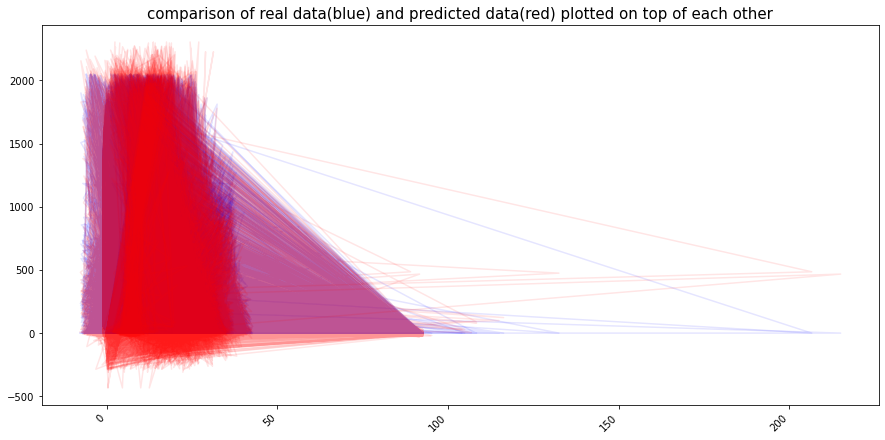

In [24]:
plt.figure(figsize=(15,7))
plt.plot(x_test.values, y_test.values, color = 'blue', alpha=0.1)
plt.plot(x_test.values, rbf_predict, color = 'red', alpha=0.1)
plt.title('comparison of real data(blue) and predicted data(red) plotted on top of each other', fontsize=15)
plt.xticks(rotation=90)
plt.xticks(rotation=45, ha='right')
plt.show()

In [25]:
sort = data.sort_values(by=["Date_time"], inplace=False)
time = sort["Date_time"]
lasttwentyPecent = time.iloc[int(-43128):]

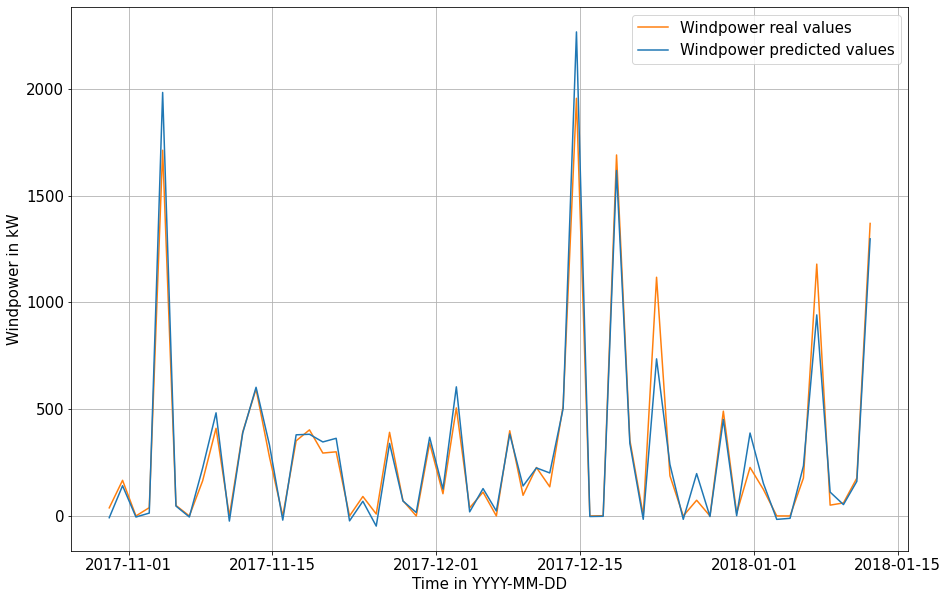

In [26]:
plt.rc('font', size=15)
fig, ax = plt.subplots(figsize=(15, 10))

x1 = lasttwentyPecent[::750]
y1 = y_test[::750]
y2 = rbf_predict[::750]

ax.plot(x1, y1, color='tab:orange', label='Windpower real values')
ax.plot(x1, y2, color='tab:blue', label='Windpower predicted values')
ax.set_xlabel('Time in YYYY-MM-DD')
ax.set_ylabel('Windpower in kW')
ax.set_title('')
ax.grid(True)
ax.legend(loc='upper right');

#### calculate CRPS:

In [27]:
# CRPS: a scalar, representing the mean CRPS for the data
# https://pypi.org/project/ensverif/#description

import ensverif # from Laval-University Kanada

emp = ensverif.crps.crps(rbf_predict, y_test, distribution = 'emp')
gaussian = ensverif.crps.crps(rbf_predict, y_test, distribution = 'normal_exact')
gamma = ensverif.crps.crps(rbf_predict, y_test, distribution = 'gamma_approx')

print("empirical:",emp)
print("gaussian:",gaussian)
print("gamma:",gamma)

empirical: 122.1879696248958
gaussian: 193.0835962656202
gamma: nan


In [31]:
# crps_hersbach_decomposition output:
# CRPS_tot: Scalar -> reliability + potential
# reliability: Scalar -> the reliability component of the CRPS
# potential: Scalar -> the potential CRPS that would be reached for a perfectly reliable system
crps_hersbach_decomposition = ensverif.crps_hersbach_decomposition.crps_hersbach_decomposition(rbf_predict, y_test)
print("crps_hersbach_decomposition", crps_hersbach_decomposition)

crps_hersbach_decomposition (122.1879696248952, 122.1778997347748, 0.010069890120407085)


##### We can calculate Shapley Values:

- we need to sample to get a smaller size due to the big runtime

In [29]:
sampleX = x_test.sample(100)

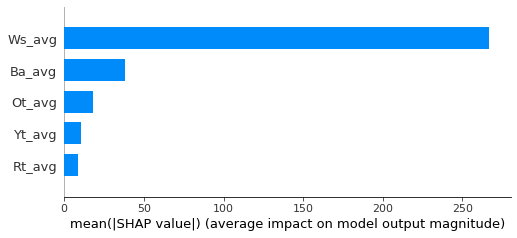

In [33]:
# compute the SHAP values for the linear model
explainer = shap.KernelExplainer(rbf_model.predict, sampleX)
shap_values = explainer.shap_values(sampleX)
shap.summary_plot(shap_values, x, plot_type="bar")

In [30]:
sampleY = x_test.sample(400)

Using 400 background data samples could cause slower run times. Consider using shap.sample(data, K) or shap.kmeans(data, K) to summarize the background as K samples.


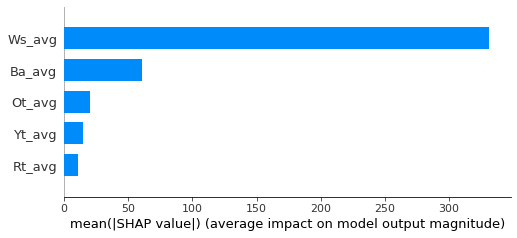

In [31]:
# compute the SHAP values for the linear model
explainer = shap.KernelExplainer(rbf_model.predict, sampleY)
shap_values = explainer.shap_values(sampleX)
shap.summary_plot(shap_values, x, plot_type="bar")

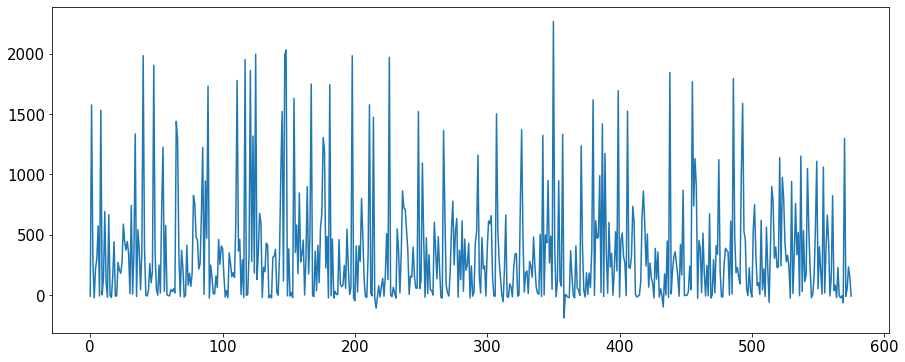

In [27]:
a = (rbf_predict)[::75]
plt.plot(a)

In [29]:
df = pd.DataFrame(rbf_predict)
a = (df < 0).sum().sum()
b = (df < -50).sum().sum()
c = (df > 0).sum().sum()

print("count negative numbers: ", a)
print("count negative numbers (<-50): ", b)
print("count positive numbers: ", c)
df.info()

count negative numbers:  8094
count negative numbers (<-50):  694
count positive numbers:  35034
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 43128 entries, 0 to 43127
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   0       43128 non-null  float64
dtypes: float64(1)
memory usage: 337.1 KB
